### Notebook created by Juico Bowley
### Email address - juico.s.bowley@gmail.com
### Github - https://github.com/Juicob

 Classifying Pneumonia with CNNs
# Overview
This project goes through the process of developing a Convolutional Neural Network with Tensorflow and Keras in order to detect healthy lungs versus those that are infected with pneumonia.
# Business Problem
The goal of this project is to help radiologists work more effectively and efficiently by providing a tool they can use to pre-screen chest X-rays to implement a triage system with minimal to no human overhead.
# Data
The data was gathered from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The data files provide a pre-split folder breakdown of test/train/validation files while also being separated into each class, normal/pneumonia.

In [1]:
import os
import sys
import datetime
import itertools
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics

import visualkeras
from collections import defaultdict

set_seed(42)
np.random.seed(42)


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
def plot_results(results):
  """Function to convert a models results into a dataframe and plot them to show the both the accuracy and validation accuracy, as well as the loss and validation loss over epochs.

  Args:
      results_dataframe (dataframe): 
  """

  results_dataframe = pd.DataFrame(results)

  fig = px.line(results_dataframe, x=results_dataframe.index, y=["accuracy","val_accuracy"])
  fig.update_layout(title='Accuracy and Validation Accuracy over Epochs',
                    xaxis_title='Epoch',
                    yaxis_title='Percentage',
                )
  fig.update_traces(mode='lines+markers')
  fig.show()

  fig = px.line(results_dataframe, x=results_dataframe.index, y=['loss','val_loss'])
  fig.update_layout(title='Loss and Validation Loss over Epochs',
                    xaxis_title='Epoch',
                    yaxis_title='idek what this unit is - change me'
                )
  fig.update_traces(mode='lines+markers')
  fig.show()

def plotImages(images_arr, labels_arr):
    """[Displays the images from the given array with their labels]
    """

    labels_arr = ['Normal: 0' if label == 0 else 'Pneumonia: 1' for label in labels_arr]
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, 
                              labels_arr, 
                              axes):
        ax.imshow(img)
        ax.set_title(label, size=18)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def evaluate_results(model): 
    """[Instantiates the models predictions and creates a confusion matrix of the results]
    """
    predictions = model.predict(X_test).round()
    cm = metrics.confusion_matrix(y_test, 
                                  predictions,
                                  normalize='true')

    ax = sns.heatmap(cm, cmap='Blues',annot=True,square=True)
    ax.set(xlabel='Predicted Class',ylabel='True Class')
    print(metrics.classification_report(y_test, predictions))
  

# Setting up paths

In [4]:

train_normal = os.path.join('../project_image_data/train/NORMAL')
train_pneumonia = os.path.join('../project_image_data/train/PNEUMONIA')


test_normal = os.path.join('../project_image_data/test/NORMAL')
test_pneumonia = os.path.join('../project_image_data/test/PNEUMONIA')

val_normal = os.path.join('../project_image_data/val/NORMAL')
val_pneumonia = os.path.join('../project_image_data/val/PNEUMONIA')

all_paths = [train_normal, train_pneumonia, test_normal, test_pneumonia, val_normal, val_pneumonia]


# Show number of files for each class in each folder

In [5]:

for path in all_paths:
    print(f'{path} has  {len(os.listdir(path))}  files')


../project_image_data/train/NORMAL has  1303  files
../project_image_data/train/PNEUMONIA has  1303  files
../project_image_data/test/NORMAL has  234  files
../project_image_data/test/PNEUMONIA has  390  files
../project_image_data/val/NORMAL has  46  files
../project_image_data/val/PNEUMONIA has  46  files


# Normalize image size and load into generator

In [6]:
# All images will be rescaled by 1./255
img_datagen = ImageDataGenerator(rescale=1./255)
 
# Flow training images in batches of 128 using train_datagen generator
train_generator = img_datagen.flow_from_directory('../project_image_data/train/',  # Source dir for training images
                                                  target_size=(64, 64),  # All images will be resized to 64x64
                                                  batch_size=2606,
                                                  color_mode='grayscale',
                                                  # Since we use binary_crossentropy loss, we need binary labels
                                                  class_mode='binary')

val_generator = img_datagen.flow_from_directory('../project_image_data/val/', 
                                                 target_size=(64, 64),
                                                 batch_size=92,
                                                 color_mode='grayscale',
                                                 class_mode='binary')

test_generator = img_datagen.flow_from_directory('../project_image_data/test/',
                                                 target_size=(64, 64),
                                                 batch_size=624, 
                                                 color_mode='grayscale',
                                                 class_mode='binary',
                                                 shuffle=False)       

Found 2606 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
X_train,y_train = next(train_generator)
X_test,y_test = next(test_generator)
X_val,y_val = next(val_generator)


# Show pictures

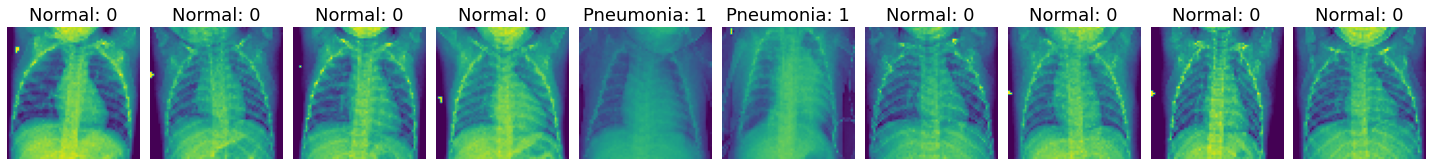

[0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
(64, 64, 1)


In [8]:
plotImages(X_train, y_train)
print(y_train[:10])
print(X_train[0].shape)


In [9]:
## Verify labels

In [10]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Begin modelling

In [11]:

RMSprop_32_64 = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    # Only 1 output neuron. It will contain a value from 0-1
    tf.keras.layers.Dense(1, activation='sigmoid')
])
RMSprop_32_64.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12545     
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
____________________________________________________

In [12]:
%%time
RMSprop_32_64.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy',tf.keras.metrics.Recall()])

Wall time: 11 ms


In [13]:
tensorboard = TensorBoard(log_dir=f'./logs/RMSprop_32_64_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
earlystop = tf.keras.callbacks.EarlyStopping(patience=3, verbose=True)

In [14]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/RMSprop_32_64', verbose=1, save_best_only=True, mode='auto')
history1 = RMSprop_32_64.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100, 
      verbose=1,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
 1/21 [>.............................] - ETA: 0s - loss: 0.6948 - accuracy: 0.4766 - recall: 0.0000e+00WARNING:tensorflow:From C:\Users\Juice\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
21/21 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5767 - recall: 0.1711
Epoch 00001: val_loss improved from inf to 0.67480, saving model to ./checkpoints\RMSprop_32_64
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./checkpoints\RMSprop_32_64\assets
21/21 [==============================] - 1s 71ms/step - loss: 0.6796 - accuracy: 0.57

              precision    recall  f1-score   support

         0.0       0.88      0.72      0.79       234
         1.0       0.85      0.94      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



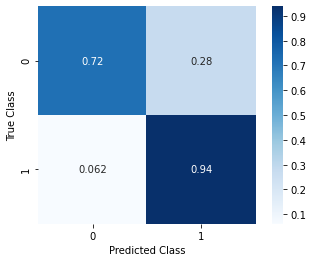

In [15]:
plot_results(history1.history)
evaluate_results(RMSprop_32_64)

In [16]:
Adam_32_64 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_64.summary()
Adam_32_64.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12545     
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
__________________________________________________

In [17]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_64_', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_64_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history2 = Adam_32_64.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
19/21 [==========================>...] - ETA: 0s - loss: 0.6427 - accuracy: 0.6682 - recall_1: 0.5523
Epoch 00001: val_loss improved from inf to 0.55098, saving model to ./checkpoints\Adam_32_64_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_\assets
21/21 [==============================] - 2s 76ms/step - loss: 0.6370 - accuracy: 0.6781 - recall_1: 0.5672 - val_loss: 0.5510 - val_accuracy: 0.7174 - val_recall_1: 1.0000
Epoch 2/100
18/21 [========================>.....] - ETA: 0s - loss: 0.4288 - accuracy: 0.8385 - recall_1: 0.8454
Epoch 00002: val_loss improved from 0.55098 to 0.32750, saving model to ./checkpoints\Adam_32_64_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_\assets
21/21 [==============================] - 1s 40ms/step - loss: 0.4209 - accuracy: 0.8423 - recall_1: 0.8473 - val_loss: 0.3275 - val_accuracy: 0.8478 - val_recall_1: 0.9783
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - loss: 0.2781 - accuracy: 0.8964 - rec

              precision    recall  f1-score   support

         0.0       0.92      0.48      0.63       234
         1.0       0.76      0.97      0.85       390

    accuracy                           0.79       624
   macro avg       0.84      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624



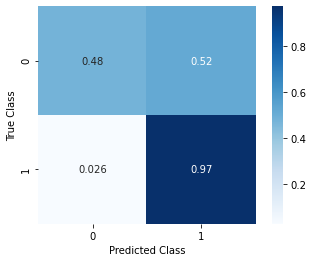

In [18]:
plot_results(history2.history)
evaluate_results(Adam_32_64)


In [19]:
Adam_32_64_64 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_64_64.summary()
Adam_32_64_64.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [20]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_64_64_', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_64_64_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history3 = Adam_32_64_64.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      callbacks=[tensorboard, earlystop, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.6573 - recall_2: 0.4551
Epoch 00001: val_loss improved from inf to 0.62064, saving model to ./checkpoints\Adam_32_64_64_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_64_\assets
21/21 [==============================] - 2s 77ms/step - loss: 0.6608 - accuracy: 0.6573 - recall_2: 0.4551 - val_loss: 0.6206 - val_accuracy: 0.6087 - val_recall_2: 1.0000
Epoch 2/100
18/21 [========================>.....] - ETA: 0s - loss: 0.4740 - accuracy: 0.7995 - recall_2: 0.8031
Epoch 00002: val_loss improved from 0.62064 to 0.31135, saving model to ./checkpoints\Adam_32_64_64_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_64_\assets
21/21 [==============================] - 2s 72ms/step - loss: 0.4633 - accuracy: 0.8062 - recall_2: 0.8112 - val_loss: 0.3114 - val_accuracy: 0.8913 - val_recall_2: 0.9348
Epoch 3/100
17/21 [=======================>......] - ETA: 0s - loss: 0.3144 - accuracy: 

              precision    recall  f1-score   support

         0.0       0.90      0.48      0.62       234
         1.0       0.76      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.74       624
weighted avg       0.81      0.78      0.76       624



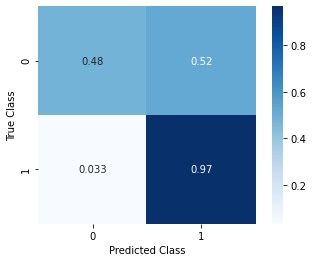

In [21]:
plot_results(history3.history)
evaluate_results(Adam_32_64_64)

In [22]:
Adam_32_64_128 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_64_128.summary()
Adam_32_64_128.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)             

In [23]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_64_128_', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_64_128_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history4 = Adam_32_64_128.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6324 - recall_3: 0.3384
Epoch 00001: val_loss improved from inf to 0.64608, saving model to ./checkpoints\Adam_32_64_128_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_128_\assets
21/21 [==============================] - 2s 88ms/step - loss: 0.6494 - accuracy: 0.6324 - recall_3: 0.3384 - val_loss: 0.6461 - val_accuracy: 0.5543 - val_recall_3: 1.0000
Epoch 2/100
16/21 [=====================>........] - ETA: 0s - loss: 0.4454 - accuracy: 0.8228 - recall_3: 0.8064
Epoch 00002: val_loss improved from 0.64608 to 0.57149, saving model to ./checkpoints\Adam_32_64_128_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_128_\assets
21/21 [==============================] - 1s 48ms/step - loss: 0.4187 - accuracy: 0.8361 - recall_3: 0.8173 - val_loss: 0.5715 - val_accuracy: 0.7500 - val_recall_3: 0.5000
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.3731 - accura

              precision    recall  f1-score   support

         0.0       0.93      0.47      0.63       234
         1.0       0.76      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.84      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624



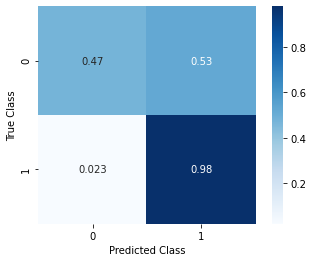

In [24]:
plot_results(history4.history)
evaluate_results(Adam_32_64_128)

In [25]:
Adam_32_64_128_256 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_64_128_256.summary()
Adam_32_64_128_256.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 256)        

In [26]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_64_128_256', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_64_128_256{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history5 = Adam_32_64_128_256.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.6190 - recall_4: 0.5211
Epoch 00001: val_loss improved from inf to 0.61464, saving model to ./checkpoints\Adam_32_64_128_256
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_128_256\assets
21/21 [==============================] - 2s 83ms/step - loss: 0.6702 - accuracy: 0.6190 - recall_4: 0.5211 - val_loss: 0.6146 - val_accuracy: 0.5652 - val_recall_4: 1.0000
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8243 - recall_4: 0.8266
Epoch 00002: val_loss improved from 0.61464 to 0.23643, saving model to ./checkpoints\Adam_32_64_128_256
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_128_256\assets
21/21 [==============================] - 2s 79ms/step - loss: 0.4065 - accuracy: 0.8243 - recall_4: 0.8266 - val_loss: 0.2364 - val_accuracy: 0.9130 - val_recall_4: 0.8478
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2

              precision    recall  f1-score   support

         0.0       0.92      0.60      0.73       234
         1.0       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.80       624
weighted avg       0.85      0.83      0.82       624



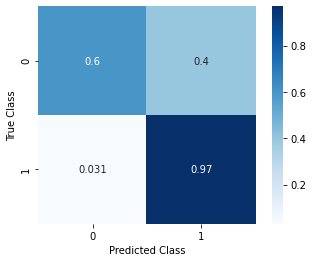

In [27]:
plot_results(history5.history)
evaluate_results(Adam_32_64_128_256)

In [28]:
Adam_32_64_64_64 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_64_64_64.summary()
Adam_32_64_64_64.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 64)         

In [29]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_64_64_64_', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_64_64_64_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history6 = Adam_32_64_64_64.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      callbacks=[earlystop, tensorboard, checkpoint], 
      validation_data=(X_val, y_val))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.6193 - recall_5: 0.3262
Epoch 00001: val_loss improved from inf to 0.65337, saving model to ./checkpoints\Adam_32_64_64_64_
21/21 [==============================] - 1s 68ms/step - loss: 0.6637 - accuracy: 0.6193 - recall_5: 0.3262 - val_loss: 0.6534 - val_accuracy: 0.5435 - val_recall_5: 1.0000
Epoch 2/100
16/21 [=====================>........] - ETA: 0s - loss: 0.4804 - accuracy: 0.7988 - recall_5: 0.8015
Epoch 00002: val_loss improved from 0.65337 to 0.58205, saving model to ./checkpoints\Adam_32_64_64_64_
21/21 [==============================] - 1s 38ms/step - loss: 0.4489 - accuracy: 0.8166 - recall_5: 0.8135 - val_loss: 0.5820 - val_accuracy: 0.7065 - val_recall_5: 0.4348
Epoch 3/100
16/21 [=====================>........] - ETA: 0s - loss: 0.4211 - accuracy: 0.8032 - recall_5: 0.7570
Epoch 00003: val_loss improved from 0.58205 to 0.26824, saving model to ./checkpoints\Adam_32_64_64_64_
21/21 

              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76       234
         1.0       0.82      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.82       624
weighted avg       0.86      0.85      0.84       624



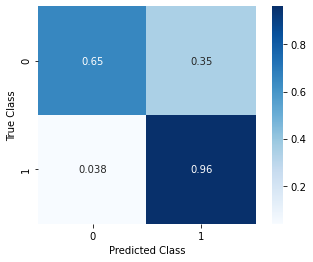

In [30]:
plot_results(history6.history)
evaluate_results(Adam_32_64_64_64)

In [31]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, verbose=True)
Adam_32_64_64_64_P5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_64_64_64_P5.summary()
Adam_32_64_64_64_P5.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 64)         

In [32]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_64_64_64_P5_', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_64_64_64_P5_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history7 = Adam_32_64_64_64_P5.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100, 
      verbose=1,
      callbacks=[tensorboard, earlystop, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
17/21 [=======================>......] - ETA: 0s - loss: 0.6796 - accuracy: 0.5570 - recall_6: 0.1089
Epoch 00001: val_loss improved from inf to 0.63007, saving model to ./checkpoints\Adam_32_64_64_64_P5_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_64_64_P5_\assets
21/21 [==============================] - 2s 91ms/step - loss: 0.6719 - accuracy: 0.5741 - recall_6: 0.1550 - val_loss: 0.6301 - val_accuracy: 0.6739 - val_recall_6: 0.8913
Epoch 2/100
16/21 [=====================>........] - ETA: 0s - loss: 0.4835 - accuracy: 0.8047 - recall_6: 0.7638
Epoch 00002: val_loss improved from 0.63007 to 0.60567, saving model to ./checkpoints\Adam_32_64_64_64_P5_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_64_64_64_P5_\assets
21/21 [==============================] - 1s 51ms/step - loss: 0.4628 - accuracy: 0.8112 - recall_6: 0.7728 - val_loss: 0.6057 - val_accuracy: 0.7283 - val_recall_6: 0.4783
Epoch 3/100
16/21 [=====================>........] - ETA: 0s - l

              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74       234
         1.0       0.80      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



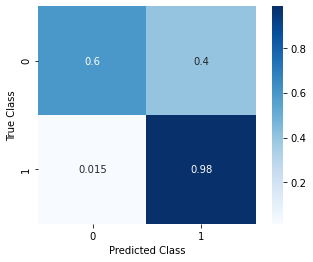

In [33]:
plot_results(history7.history)
evaluate_results(Adam_32_64_64_64_P5)

In [34]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=3, verbose=True)
Adam_32_32_32_32 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Adam_32_32_32_32.summary()
Adam_32_32_32_32.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 4, 4, 32)         

In [35]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_32_32_32_', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_32_32_32_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history8 = Adam_32_32_32_32.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100, 
      verbose=1,
      callbacks=[tensorboard, earlystop, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.6059 - recall_7: 0.3761
Epoch 00001: val_loss improved from inf to 0.66527, saving model to ./checkpoints\Adam_32_32_32_32_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_32_32_32_\assets
21/21 [==============================] - 2s 86ms/step - loss: 0.6806 - accuracy: 0.6059 - recall_7: 0.3761 - val_loss: 0.6653 - val_accuracy: 0.5217 - val_recall_7: 1.0000
Epoch 2/100
19/21 [==========================>...] - ETA: 0s - loss: 0.6110 - accuracy: 0.7019 - recall_7: 0.7551
Epoch 00002: val_loss improved from 0.66527 to 0.51573, saving model to ./checkpoints\Adam_32_32_32_32_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_32_32_32_\assets
21/21 [==============================] - 1s 51ms/step - loss: 0.6039 - accuracy: 0.7134 - recall_7: 0.7567 - val_loss: 0.5157 - val_accuracy: 0.7609 - val_recall_7: 0.5435
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - loss: 0.4359 

              precision    recall  f1-score   support

         0.0       0.91      0.61      0.73       234
         1.0       0.80      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624



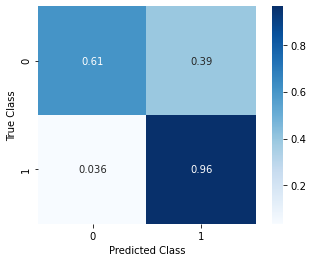

In [36]:
plot_results(history8.history)
evaluate_results(Adam_32_32_32_32)

In [37]:
Adam_32_32_32_32_2D = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
Adam_32_32_32_32_2D.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 32)         

In [39]:
Adam_32_32_32_32_2D.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])


In [40]:
%%time
checkpoint = ModelCheckpoint(filepath=r'./checkpoints/Adam_32_32_32_32_2D_', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'./logs/Adam_32_32_32_32_2D_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history9 = Adam_32_32_32_32_2D.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=100, 
      verbose=1,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5618 - recall_8: 0.4444
Epoch 00001: val_loss improved from inf to 0.67590, saving model to ./checkpoints\Adam_32_32_32_32_2D_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_32_32_32_2D_\assets
21/21 [==============================] - 2s 93ms/step - loss: 0.6856 - accuracy: 0.5618 - recall_8: 0.4444 - val_loss: 0.6759 - val_accuracy: 0.5109 - val_recall_8: 1.0000
Epoch 2/100
15/21 [====================>.........] - ETA: 0s - loss: 0.6547 - accuracy: 0.5969 - recall_8: 0.6711
Epoch 00002: val_loss improved from 0.67590 to 0.59115, saving model to ./checkpoints\Adam_32_32_32_32_2D_
INFO:tensorflow:Assets written to: ./checkpoints\Adam_32_32_32_32_2D_\assets
21/21 [==============================] - 1s 49ms/step - loss: 0.6403 - accuracy: 0.6343 - recall_8: 0.7015 - val_loss: 0.5912 - val_accuracy: 0.5978 - val_recall_8: 0.1957
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - l

              precision    recall  f1-score   support

         0.0       0.93      0.49      0.64       234
         1.0       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624



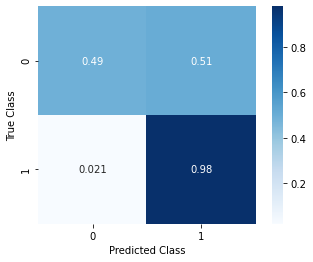

In [41]:
plot_results(history9.history)
evaluate_results(Adam_32_32_32_32_2D)

 After iterating over and running all the models I viewed the results of each as well as their compared accuracy/loss graphs via tensorboard. I found that the "Adam_32_32_32_32" model performed the best and stored the model within a separate filepath to ensure it doesn't get written over or compromised.

In [42]:
best_model = tf.keras.models.load_model('Adam_32_32_32_32__best')

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       234
         1.0       0.87      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



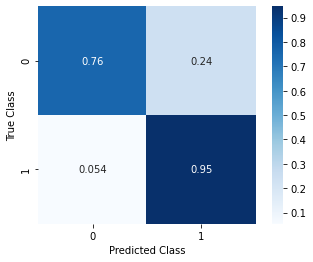

In [43]:
evaluate_results(best_model)

# Best Model
 I selected this as the best model because it had the highest accuracy at 88%. While this model does not have the highest recall which is what I would like to maximize, I believe sacrificing 4 percentage points of correctly identifying pneumonia was worth the 25% increase of correctly identifying normal lungs.

# Creating network topology visual

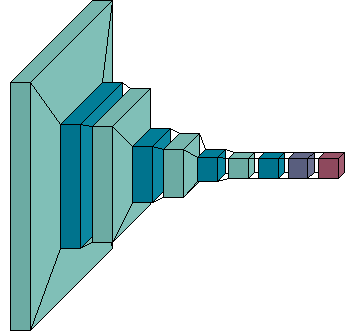

In [44]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'rgb(128,191,183)'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'rgb(11,135,161)'
color_map[Dense]['fill'] = '#a25d71'#'#928d6d'
color_map[Flatten]['fill'] = '#6d7292' #'#6d7292'

visualkeras.layered_view(best_model, color_map=color_map)
# visualkeras.layered_view(best_model, to_file='network_visual.png', color_map=color_map).show()

# Create ROC Curve

In [45]:
preds = best_model.predict(X_test)
fpr, tpr, thresh = roc_curve(y_test, preds)

# Calculate the ROC (Reciever Operating Characteristic) AUC (Area Under the Curve)
rocauc = auc(fpr, tpr)
print('Train ROC AUC Score: ', rocauc)

Train ROC AUC Score:  0.9425597194827964


In [46]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
#     marker=dict(color='fa7f72'),

    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain', tickvals=[0,0.25,0.5,0.75,1])

fig.show()


 ROC curve restates that to get a 95% true positive, we would need to be comfortable accepting a 25% false positive rate.

# Recommendations
 Based on my results throughout this process there are a few things I'd recommend if you were to go about building a model to predict pneumonia.
 * More data
   * While there were about 5 thousands images total given within the dataset. I believe that better results could be gathered if there was more data for the model to train on. CNN's will always benefit from more data as long as there are enough resources available to process it effectively.
 * Transfer Learning
   * Using transfer learning from a model that was pre-trained on x-rays with and without pneumonia would yield better results in less time and with less resources. You'll spend less time iterating on network variations as the pre-trained model will already have done most of the work. Fine tuning will take considerably less time and resources and yield just as good if not better results from the right model.
 * Resources
   * Before you decide to get into CNN's, be sure you have the appropriate resources available to you. Training a CNN over thousands of images is going to take a long time and a lot your computer's resources if you don't have sufficient RAM or GPU. If you don't have the hardware available to you, there are cloud services such as Google Colab that offer access GPU processers virtually through the cloud at low to no cost.